In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings("ignore") 

<font face=Cambria color=black size=3>
Since the hotel reviews they have received reflect user experience during their stay at the hotel, the classification model is built based on the assumption that only use customer reviews to analyze the review score. It could be considered as text processing and sentiment analysis task.

### 1. Load the data

In [2]:
# Load the data
hotel = pd.read_csv(r'F:\IMP_2022\KPMG\Jingjing Chen\Jingjing Chen\KPMG Lighthouse NZ Early Career Assessment\data.csv')
hotel.shape

(515738, 12)

In [3]:
hotel.head(3) 

,hotel_address,review_date,hotel_name,negative_review,positive_review,reviewer_score,tags,days_since_review,reviewer_nationality,total_number_of_reviews_reviewer_has_given,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/03/2017,Hotel Arena,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,Russia,1,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/03/2017,Hotel Arena,No Negative,No real complaints the hotel was great great ...,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,Ireland,1,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7/31/2017,Hotel Arena,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,Australia,1,52.360576,4.915968


In [4]:
# Features/Attibutes
hotel.columns

Index(['hotel_address', 'review_date', 'hotel_name', 'negative_review',
       'positive_review', 'reviewer_score', 'tags', 'days_since_review',
       'reviewer_nationality', 'total_number_of_reviews_reviewer_has_given',
       'lat', 'lng'],
      dtype='object')

In [5]:
# Check missing value
hotel.isnull().sum().sort_values(ascending=False)
# print(hotel[hotel.isnull().values==True])

lat                                           3268
lng                                           3268
hotel_address                                    0
review_date                                      0
hotel_name                                       0
negative_review                                  0
positive_review                                  0
reviewer_score                                   0
tags                                             0
days_since_review                                0
reviewer_nationality                             0
total_number_of_reviews_reviewer_has_given       0
dtype: int64

In [6]:
df = hotel.copy()

### 2. Exploratory Data Analysis

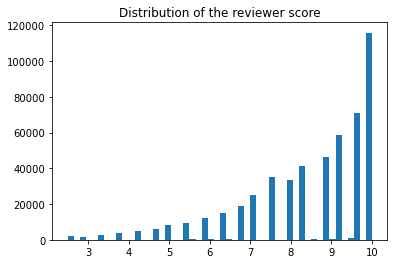

In [7]:
# The distribution of reviewer score
x = df['reviewer_score']
plt.hist(x, bins = 50)
plt.title('Distribution of the reviewer score')
plt.show()

In [8]:
# Explore the value in a single column
num_no_negtive = len(df[df["negative_review"]=="No Negative"])  #127890
num_no_positive = len(df[df["positive_review"]=="No Positive"])  #35946
print("The number of negative_review including 'No Negative' is: ", num_no_negtive)
print("The number of positive_review including 'No Positive'is: ",num_no_positive)

The number of negative_review including 'No Negative' is:  127890
The number of positive_review including 'No Positive'is:  35946


<font face=Cambria color=black size=3>
It is worth noticing that the negative_review column includes many 'No Negative' customer reviews, and similarly, the positive_review column includes 'No Positive' reviews, which would be removed in the data preprocessing step. 

### 3. Data Preprocessing

<font face=Cambria color=black size=3>
Since the classification task requires labels, the reviewer scores will be converted from floating-point numerical data to category data by setting a threshold (whether reviewer_score is greater than nine). 

In [9]:
# Create the label/target column for this classification task
df["review_class"] = df["reviewer_score"].apply(lambda x: 1 if x > 9 else 0)
df.head(3)

,hotel_address,review_date,hotel_name,negative_review,positive_review,reviewer_score,tags,days_since_review,reviewer_nationality,total_number_of_reviews_reviewer_has_given,lat,lng,review_class
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/03/2017,Hotel Arena,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,Russia,1,52.360576,4.915968,0
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/03/2017,Hotel Arena,No Negative,No real complaints the hotel was great great ...,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,Ireland,1,52.360576,4.915968,0
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7/31/2017,Hotel Arena,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,Australia,1,52.360576,4.915968,0


<font face=Cambria color=black size=3>
The column named 'review_class' is our target variable (i.e., the variable which we want to predict). The two possible classes are '1' (Yes) and '0' (No). This means our prediction problem is a binary classification problem.

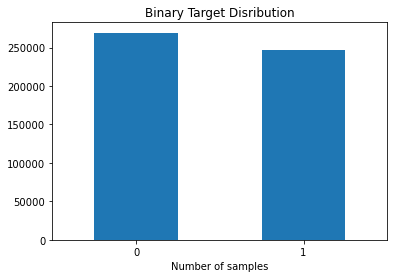

In [10]:
df_label = df['review_class'].value_counts()
value = df['review_class'].unique()
ax = df_label.plot.bar(x=value, y=df_label, rot=0)
plt.xlabel("Number of samples")
plt.title("Binary Target Disribution");

<font face=Cambria color=black size=3>
As the aboved bar chart shown, this is a balanced dataset, and no need to be sampled.

In [11]:
label_counts = df['review_class'].value_counts() 
label_counts

0    269348
1    246390
Name: review_class, dtype: int64

### 3.1 Create extra features

In [12]:
# Merge two column to add a column including all review
df["review"] = df["negative_review"] + df["positive_review"]
df.head(3)

,hotel_address,review_date,hotel_name,negative_review,positive_review,reviewer_score,tags,days_since_review,reviewer_nationality,total_number_of_reviews_reviewer_has_given,lat,lng,review_class,review
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/03/2017,Hotel Arena,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,Russia,1,52.360576,4.915968,0,I am so angry that i made this post available...
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/03/2017,Hotel Arena,No Negative,No real complaints the hotel was great great ...,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,Ireland,1,52.360576,4.915968,0,No Negative No real complaints the hotel was g...
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7/31/2017,Hotel Arena,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,Australia,1,52.360576,4.915968,0,Rooms are nice but for elderly a bit difficul...


In [13]:
# Data cleaning - remove 'No Negative' or 'No Positive' from text
df["review"] = df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [14]:
# Removing stop words before counting
stop_words = stopwords.words('english')
len(stop_words)
# stop_words[5]

179

In [15]:
# Keep these words since they are important for evaluating the review score
stop_words.remove("no")
stop_words.remove("not")
stop_words.remove("nor")
len(stop_words)

176

In [16]:
# Add a column for filtered review with stopwords
df["filtered_review"] = [" ".join([word for word in text.split() if word.lower() not in stop_words]) for text in df['review']]
print(df.shape)
df.head(3)

(515738, 15)


,hotel_address,review_date,hotel_name,negative_review,positive_review,reviewer_score,tags,days_since_review,reviewer_nationality,total_number_of_reviews_reviewer_has_given,lat,lng,review_class,review,filtered_review
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/03/2017,Hotel Arena,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,Russia,1,52.360576,4.915968,0,I am so angry that i made this post available...,angry made post available via possible sites u...
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,8/03/2017,Hotel Arena,No Negative,No real complaints the hotel was great great ...,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,Ireland,1,52.360576,4.915968,0,No real complaints the hotel was great great ...,No real complaints hotel great great location ...
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7/31/2017,Hotel Arena,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,Australia,1,52.360576,4.915968,0,Rooms are nice but for elderly a bit difficul...,Rooms nice elderly bit difficult rooms two sto...


In [17]:
X = df['filtered_review']
y = df['review_class']
X.head(3)

0    angry made post available via possible sites u...
1    No real complaints hotel great great location ...
2    Rooms nice elderly bit difficult rooms two sto...
Name: filtered_review, dtype: object

In [18]:
y.head(3)

0    0
1    0
2    0
Name: review_class, dtype: int64

In [19]:
# Split the train data and test data by rate 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=45)

<font face=Cambria color=black size=3>
Splitting the dataset into a validation set is to prevent our model from overfitting, and perform well on unseen data.

In [20]:
#TFIDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

<font face=Cambria color=black size=3>
TF-IDF Vector representation is integer counts to weighted TF-IDF scores. Vectorizing these texts using TF-IDF is useful in text classification because it focuses on the frequency and the importance of words present in the text files.

### 4. Build a model and Evaluation

<font face=Cambria color=black size=3>
Logistic regression is a supervised learning classification algorithm used to predict the probability of a target variable by using a given set of independent variables. It is one of the most classical Machine Learning algorithms and usually has good performance.
In this task, Logistic Regression classifier is applied to solve a binary classification problem.

In [21]:
# Build a model
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)
y_pred_lr = lr.predict(X_test_vec)
print('accuracy score: %0.4f'% accuracy_score(y_test, y_pred_lr))  #0.7620

accuracy score: 0.7617


<font face=Cambria color=black size=3>
Accuracy:<br>
The distribution of the classes in data is balanced, accuracy is metric to show the model performance for the classification task, the higher the better. Accuracy is 76%, which is the number of times the model predicted the correct label overall labels in the dataset.

In [22]:
#Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
print(tn, fp, fn, tp)
tpr_lr = round(tp/(tp + fn), 4)
tnr_lr = round(tn/(tn+fp), 4)
print(tpr_lr, tnr_lr)

42065 11747 12835 36501
0.7398 0.7817


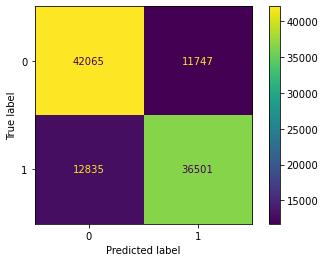

In [23]:
# print(confusion_matrix(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lr.classes_)
disp.plot()
plt.show()

<font face=Cambria color=black size=3>
From the confusion matrix:<br>
The model predicted 42065 labels correctly as Negative and 36501 labels correctly as Positive.
However, 12835 labels are predicted as Positives while they are Negatives (False Negatives).
The model predicted 11747 labels as Negatives but actually, they are Positives (False Positives).

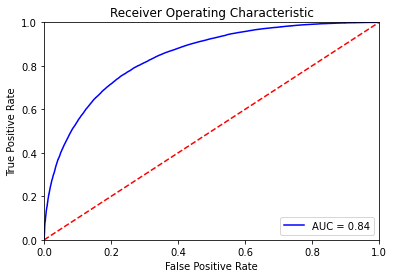

In [24]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test_vec)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<font face=Cambria color=black size=3>
A receiver operating characteristic curve (ROC curve), is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. <br>
Classifiers that give curves closer to the top-left corner indicate better performance. <br>
The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.
It can be seen in this plot, AUC=0.84. The model performs well.

### 5. Prediction

In [25]:
X_test_vec1 = vectorizer.transform(X_test)
sample_predict = lr.predict(X_test_vec1)
print(sample_predict)

[0 0 1 ... 1 0 0]


In [26]:
column_names = ["pred"]
df_p = pd.DataFrame(sample_predict,columns=column_names)
df_p["pred"].replace([0,1],['No','Yes'],inplace=True)
# df_p

In [27]:
df_s = pd.DataFrame(X_test)
# print(df_s.shape)  #(103148, 1)
# print(df_p.shape)  #(103148, 1)
df_igno_idx = pd.concat([df_s.reset_index(),df_p.reset_index()], axis=1)
# print(df_igno_idx)
df_text_pred = df_igno_idx[['filtered_review', 'pred']]
print(df_text_pred)

                                          filtered_review pred
0       Whenever Breakfast Tea brought room always col...   No
1       Mattress good place close Puerto Olimpico Movi...   No
2       Breakfast staff seemed little harrassed Buffet...  Yes
3       No view Room Another building front like suffo...   No
4       Breakfast Buffet poor Standard price ridiculou...   No
...                                                   ...  ...
103143         Nice breakfast fantastic location shopping  Yes
103144  room felt little clinical lacked personality P...   No
103145                    comfortable close metro station  Yes
103146  Lighting terrible Impossible read ordinary boo...   No
103147    expensive probably line nice hotels London nice   No

[103148 rows x 2 columns]


<font face=Cambria color=black size=3>
This Logistic regression classification model on the test data to predict whether the reviewer_score is greater than nine. The first column shows the review(after filtered), and the second column displays the predicted label (Yes or No) corresponding.<br>
Yes - means reviewer_score is greater than nine. And vice versa.